In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pythermalcomfort.models import set_tmp

In [63]:
df = pd.read_csv('CN_DB.csv')
df.head()

,suject_id,timestamp,season,city,climate,building_type,cooling_type,gender,age,ht,...,met,ta,rh,vel,tg,top,tr,t_out,latitude,set
0,1,1/30/19 10:35,Winter Season,HebeiHandan,Cold zone,Residential,Radiator heating,Female,18-30,170.0,...,1.0,21.5,32.0,0.0,20.9,20.8,20.9,0.4,36.62,24.0
1,2,1/30/19 10:42,Winter Season,HebeiHandan,Cold zone,Residential,Radiator heating,Female,41-50,168.0,...,0.9,21.5,32.0,0.0,20.9,20.8,20.9,0.4,36.62,NaN
2,3,1/30/19 10:45,Winter Season,HebeiHandan,Cold zone,Residential,Radiator heating,Male,41-50,170.0,...,0.9,21.5,32.0,0.0,20.9,20.8,20.9,0.4,36.62,NaN
3,4,1/30/19 10:47,Winter Season,HebeiHandan,Cold zone,Residential,Radiator heating,Male,18-30,178.0,...,0.9,21.5,32.0,0.0,20.9,20.8,20.9,0.4,36.62,NaN
4,5,1/31/19 20:20,Winter Season,HebeiHandan,Cold zone,Residential,Radiator heating,Male,18-30,174.0,...,0.9,20.9,33.0,0.0,19.8,20.0,19.8,0.4,36.62,NaN


In [71]:
# total rows of df, and rows with valid values in SET
print(len(df), df['set'].isnull().sum())

15992 3529


In [49]:
# only keep rows with valid SET values
df = df.dropna(subset=['set'])

In [50]:
# check cooling_type unique values
df['cooling_type'].unique()

array(['Radiator heating', 'Convection heating', 'Radiant floor heating',
       'Naturally Ventilated', 'Ceiling capillary heating',
       'Air conditioning heating', 'Others', 'self-heating',
       'Furnace heating', 'Floor radiation + fan coil',
       'Small electric heater heating'], dtype=object)

In [51]:
for i in ['HenanNanyang', 'Shanghai', 'HubeiWuhan', 'Lhasa', 'HunanChangsha', 'YunnanKunming']:
    print(i)
    print(df[df['city'] == i]['cooling_type'].value_counts())
    print("***************************************\n")

HenanNanyang
Air conditioning heating    95
Naturally Ventilated        51
Name: cooling_type, dtype: int64
***************************************

Shanghai
Radiant floor heating            659
Convection heating               636
Naturally Ventilated             239
Air conditioning heating         169
Small electric heater heating      8
Others                             3
Name: cooling_type, dtype: int64
***************************************

HubeiWuhan
Naturally Ventilated    125
Name: cooling_type, dtype: int64
***************************************

Lhasa
Naturally Ventilated    157
self-heating             74
Convection heating        3
Radiator heating          1
Name: cooling_type, dtype: int64
***************************************

HunanChangsha
Naturally Ventilated    577
Convection heating      444
Name: cooling_type, dtype: int64
***************************************

YunnanKunming
Naturally Ventilated    368
Name: cooling_type, dtype: int64
**********************

In [53]:
# group by city, using mean values
df_city = df.groupby('city').agg(
    records=('city', 'size'),
    thermal_sensation=('thermal_sensation', 'mean'),
    thermal_comfort=('thermal_comfort', 'mean'),
    thermal_acceptability=('thermal_acceptability', 'mean'),
    ta=('ta', 'mean'),
    top=('top', 'mean'),
    clo=('clo', 'mean'),
    set=('set', 'mean'),
    latitude=('latitude', 'mean'),
    t_out=('t_out', 'mean')
).reset_index()

# calcualte the percentage of Radiator heating for each city and assign the value to df_city
df_city['p_heating'] = df_city['city'].apply(lambda x: df[df['city'] == x]['cooling_type'].value_counts().get('Radiator heating', 0) / df[df['city'] == x]['cooling_type'].count())

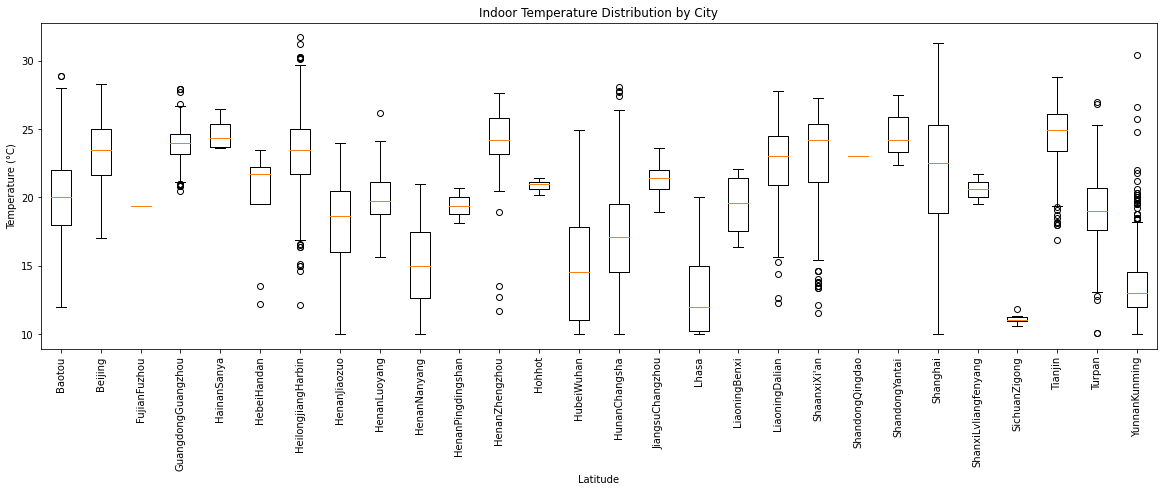

In [55]:
# box plot the indoor temperature distribution by city, show latitude as x-axis
plt.figure(figsize=(20, 6))
plt.boxplot([df[df['city'] == city]['ta'] for city in df_city['city']], labels=df_city['city'])
plt.title('Indoor Temperature Distribution by City')
plt.xlabel('Latitude')
plt.ylabel('Temperature (°C)')
plt.xticks(rotation=90)  # Rotate x-axis labels by 45 degrees
plt.show()